In [184]:
import sys
sys.path.append('../../plots')   
from aj_plt_templates import (draw_basis)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.spatial.transform import Rotation as R

# Gram-Schmidt procedure
This method allows to create an orthogonal basis (Coordinate System- CS) from N non-co-planar vectors. Principle is simple:

Take first vector v1 as a first new basis. Second vector can be decomposed into parallel and perpendicular compoenents to v1 => U2 = U2_prllel + U2_prpnd. Parallel component is just a projection onto v1. For orthogonal basis we need U2_prpnd, which can be solved for U2_prpnd = U2 - U2_prllel. repeate with next vectors.

In [185]:
def orthoganalize_rows(arr):
    """ do it element-row wise """
    row_norms = np.linalg.norm(arr, axis=1)
    return (arr.T / row_norms).T

def gram_schmidt(u1,u2,u3=None):
    if u3 is None:
        u3 = np.cross(u1,u2)    # ORTHOGONAL TO BOTH
    v1 = u1
    v2 = u2 - np.dot(u2,u1)/np.dot(v1,v1)*v1
    v3 = u3 - np.dot(u3,u1)/np.dot(v1,v1)*v1 - np.dot(u3,u2)/np.dot(v2,v2)*v2
    u_out = orthoganalize_rows(np.array([u1,u2,u3]))
    v_out = orthoganalize_rows(np.array([v1,v2,v3]))
    return v_out, u_out

u1 = np.array([-0.25,1,0], float)
u2 = np.array([-0.5,1,1], float)

exyz_prim, exyz_og = gram_schmidt(u1,u2)
print(exyz_prim)
ij = [[0,1],[0,2],[1,2]]
[print(f'dot(v[{i}],v[{j}]) = {np.dot(exyz_prim[i],exyz_prim[j])}') for i,j in ij];




[[-0.24253563  0.9701425   0.        ]
 [-0.22866478 -0.0571662   0.97182532]
 [ 0.94280904  0.23570226  0.23570226]]
dot(v[0],v[1]) = -6.938893903907228e-18
dot(v[0],v[2]) = 0.0
dot(v[1],v[2]) = 0.0


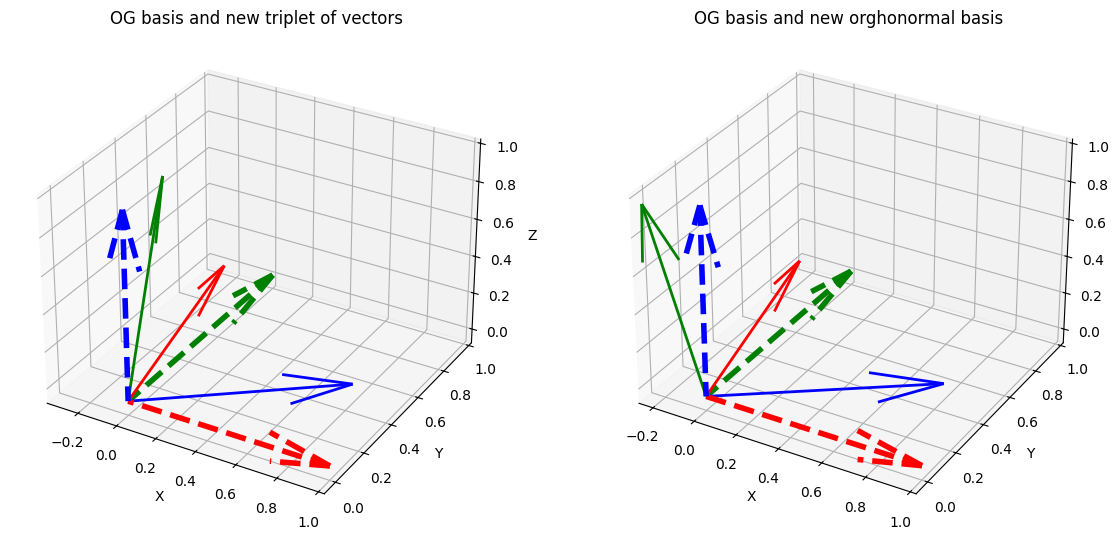

In [186]:

fig, ax = plt.subplots(1, 2, figsize=(14, 8), subplot_kw=dict(projection='3d'))

draw_basis(ax[0], ls=['dashed']*3, linewidth = 4)
draw_basis(ax[0], exyz_og, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'], linewidth = 2)
ax[0].set_title(f'OG basis and new triplet of vectors')
draw_basis(ax[1], ls=['dashed']*3, linewidth = 4)
draw_basis(ax[1], exyz_prim, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'], linewidth = 2)
ax[1].set_title(f'OG basis and new orghonormal basis');

# If you know how {x,y,z}  = {[1,0,0],[0,1,0],[0,0,1]} maps to {x',y',z'}, then you have a transformation matrix from R to R' (or other way around :C).

[ 1. -0. -0.]
(100, 3)
(3, 100)


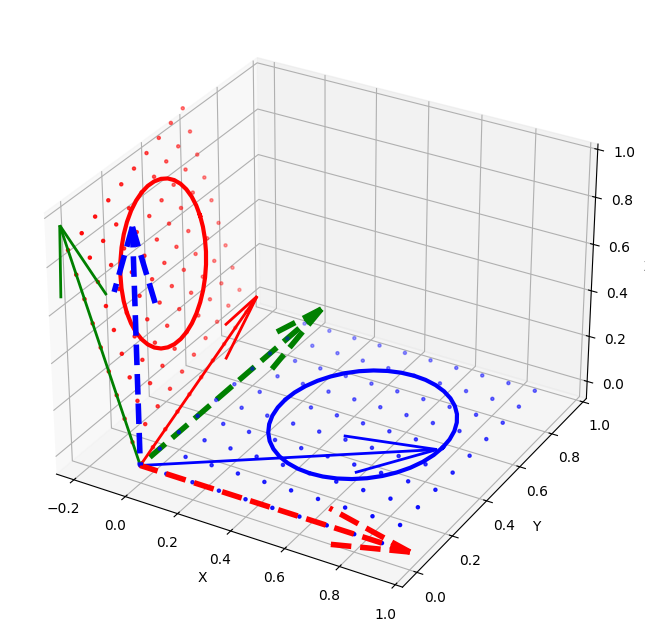

In [187]:
exyz_og = orthoganalize_rows(exyz_og)
# exyz_prim maps DOCS to new CS.
print(np.round(exyz_prim @ exyz_og[0], 5))

x_to_prim = exyz_prim
prim_to_x = np.linalg.inv(x_to_prim)

# generate a plane segment in DOCS
dr = 0.10
xy_plane_dec = np.array([[i,j,0] for i in np.arange(0,1,dr) for j in np.arange(0,1,dr)])
print(xy_plane_dec.shape)
xy_plane_prim = prim_to_x @ xy_plane_dec.T
print(xy_plane_prim.shape)
fig, ax = plt.subplots(1, 1, figsize=(14, 8), subplot_kw=dict(projection='3d'))
ax = [ax]
draw_basis(ax[0], ls=['dashed']*3, linewidth = 4)
draw_basis(ax[0], exyz_prim, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'], linewidth = 2)
ax[0].scatter(*xy_plane_prim,s = 5,c='r')
ax[0].scatter(*xy_plane_dec.T,s = 5,c='b')

t = np.arange(0,2*np.pi+0.001, np.pi/20)
A = 0.3
xy = np.array([A*np.cos(t) + 0.5, A*np.sin(t) + 0.5, 0*t]) 
xy_prim = prim_to_x @ xy

ax[0].plot(*xy_prim , c = 'r', lw=3)
ax[0].plot(*xy      , c = 'b', lw=3);




# Coordinate transformations via rotation. 
Chained rotation about selected axis. Here i rotate selected vectors and construct a map after.

Transformation matrices affect all vectors [x,y,z] and they can be chained to produce a composite rotation matrix.

Relative angles and distances are preserved under rotation transform. Its maybe more difficult to draw a shape in arbitrary orientation in comparison to DOCS. You might draw it the easy way and apply reverse CS transform on data.

u1 coordinates in R' [1. 0. 0.]
u2 coordinates in R' [0.81915 0.57358 0.     ]
angle in R  :  35.0
angle in R' :  35.0


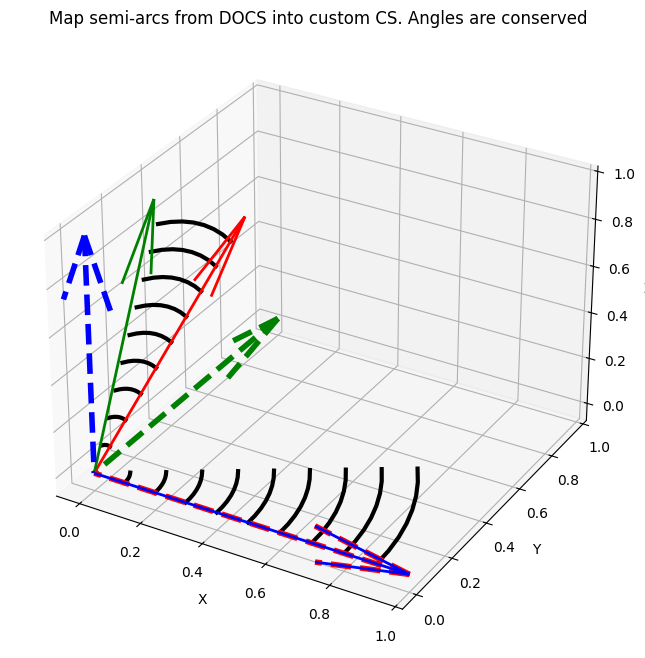

In [190]:
u1 = np.array([0,1,0], float)
u1 /= np.linalg.norm(u1)

Rx = R.from_euler('x', 35, degrees=True)
#Rz = R.from_euler('z', 15, degrees=True)
u1 = Rx.apply(u1)   # rotate u1 about x axis.
u2 = Rx.apply(u1)   # u2 is u1 rotated more about x axis.

# get transform. have to get and use an inverse transform
def draw_arc_between_vectors(u1,u2, test = False):
    x_to_prim, exyz_og = gram_schmidt(u1,u2)
    angle       = np.arccos(np.clip(np.dot(u1,u2),-1,1))
    if test:
        u1_prim = x_to_prim @ u1
        u2_prim = x_to_prim @ u2
        print('u1 coordinates in R\'',np.round(u1_prim, 5))
        print('u2 coordinates in R\'',np.round(u2_prim, 5))
        angle_prim  = np.arccos(np.clip(np.dot(u1_prim,u2_prim),-1,1))
        print('angle in R  : '  , np.round(np.degrees(angle     ),5))
        print('angle in R\' : ' , np.round(np.degrees(angle_prim),5))

    t = np.arange(0,angle+0.001, np.pi/40)
    xy = np.array([np.cos(t),np.sin(t),0*t])

    prim_to_x = np.linalg.inv(x_to_prim)
    return prim_to_x @ xy

xy_prim = draw_arc_between_vectors(u1,u2,True)
fig, ax = plt.subplots(1, 1, figsize=(14, 8), subplot_kw=dict(projection='3d'))
ax = [ax]
draw_basis(ax[0], ls=['dashed']*3, linewidth = 4)
draw_basis(ax[0], exyz_og, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'], linewidth = 2)

for r in np.arange(0.1,1,0.1):
    ax[0].plot(*xy_prim*r, c = 'k', lw=3)
    ax[0].plot(*xy*r, c = 'k', lw=3)

ax[0].set_title(f'Map semi-arcs from DOCS into custom CS. Angles are conserved');



# Coordinate transformations via Euler rotation. 
Here is an example of Euler rotation. In this case coordinate frame rotates with object and its easy to interpret composite rotation result.

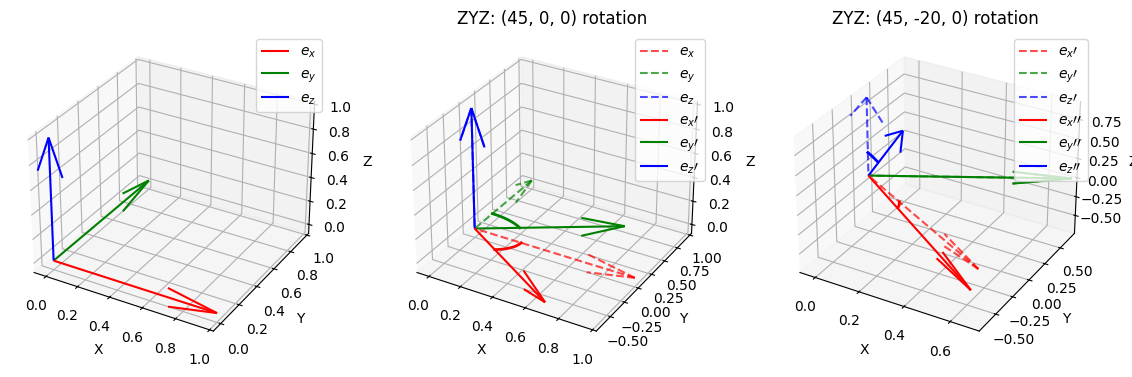

In [205]:

fig, ax = plt.subplots(1, 3, figsize=(14, 8), subplot_kw=dict(projection='3d'))

draw_basis(ax[0])
ax[0].legend()
Z1 = 45
Y = -20
Z2 = 0
# first rotation
draw_basis(ax[1], alpha=0.7, ls=['dashed']*3)

r1 = R.from_euler('zyz', [Z1, 0, 0], degrees=True)
exyz = np.eye(3).astype(float)
exyz_prim = np.dot(r1.as_matrix(), exyz)

draw_basis(ax[1], exyz_prim, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'])
arc1 = draw_arc_between_vectors(exyz[0],exyz_prim[0],False)
arc2 = draw_arc_between_vectors(exyz[1],exyz_prim[1],False)
ax[1].plot(*arc1*0.3, c = 'r', lw=2)
ax[1].plot(*arc2*0.3, c = 'g', lw=2)

ax[1].set_title(f'ZYZ: {Z1,0,0} rotation')
ax[1].legend()

# draw second rotation
draw_basis(ax[2], exyz_prim, alpha=0.7, ls=['dashed']*3, clrs = ['r','g','b'], lbls = ['$e_x\prime$', '$e_y\prime$','$e_z\prime$'])

r2 = R.from_euler('zyz', [Z1, Y, 0], degrees=True)
exyz_prim_prim = np.dot(r2.as_matrix(), np.eye(3))
draw_basis(ax[2], exyz_prim_prim, clrs = ['r','g','b'], lbls = ['$e_x\prime\prime$', '$e_y\prime\prime$','$e_z\prime\prime$'])

arc1 = draw_arc_between_vectors(exyz_prim[0],exyz_prim_prim[0],False)
arc2 = draw_arc_between_vectors(exyz_prim[2],exyz_prim_prim[2],False)
ax[2].plot(*arc1*0.3, c = 'r', lw=2)
ax[2].plot(*arc2*0.3, c = 'b', lw=2)


ax[2].set_title(f'ZYZ: {Z1,Y,0} rotation')
ax[2].legend()



plt.show()